In [58]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial import Delaunay
from scipy.optimize import linprog
from scipy.interpolate import UnivariateSpline

# Question 8

You are preparing a robotic unicycle to take part in a circus act.
For most of the show, a talented acrobat rides the unicycle.
But at one point, the acrobat jumps off the unicycle onto a trapeze.
After a short trapeze act, the acrobat leaps through the ring of fire in the center of the stage to land on the waiting unicycle, which has moved autonomously to the other
side.
Your job is to plan a path for the unicycle to take around the ring of fire to the acrobat’s landing point.
You are given a precomputed set of paths which all begin at different points, avoid the ring of fire, and end at the destination (shown below).
You must mimic these paths as closely as possible, since they are precisely choreographed
for the circus act.
However, the acrobat is only human, and does not position the unicycle precisely at any of the paths’ starting points.

You will need to interpolate a new path from other paths with nearby starting points.

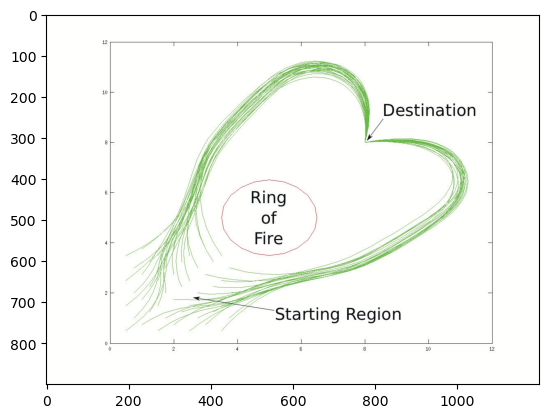

In [59]:
# Read and display image
img = plt.imread("../figs/Q8.jpg")
plt.imshow(img)

The Destination point is (8, 8). The Ring of Fire is a circle of radius 1.5 centered at (5, 5).

The precomputed paths are given in the text ﬁle paths.txt.
Every pair of lines in the text ﬁle represents a path, which is a sequence of 50 points.
The first line contains the x coordinates, and the second contains the y coordinates for one path.
The ﬁle format is:

(Notation: the superscripts (1), (2), . . . are path indices, not derivatives.)


a) Write a system of linear equations (in the form Av = b, with v representing variables of some sort, appropriately chosen) and constraints (for instance, v1 ≤ 0) that will help you determine whether a 2D point (x, y) falls within the triangle formed by three 2D points (x(i), y(i)), (x(j), y(j)), and (x(k), y(k)). (Part of the problem is to think about how
you might do this.)


b) Implement an algorithm to create a path for the unicycle as follows:

[Notation: For a path p, p(t) is the 2D point (x(t), y(t)) that describes the location of the path at time t.
Exactly what time scale you choose is up to you, so long as the unicycle’s motion starts at time t = 0.]

• Assume the algorithm is given the unicycle’s starting location at time t = 0.

• Your algorithm should first pick three paths p(i), p(j), and p(k) (from the ﬁle paths.txt), subject to some constraints described next.

• The three paths should all lie on the same side of the ring of ﬁre, all passing either to the left or all to the right of the ring.

• Your algorithm should construct a new path p as a weighted sum of these three paths. So, at each time t, p(t) = αip(i)(t) + αj p(j)(t) + αkp(k)(t), with p(0) the given starting location of the unicycle and with the weights αi, αj, αk fixed throughout.

• You should choose these weights so that p(0) lies within the triangle formed by the starting locations of the three paths that your algorithm picks, that is, within the triangle formed by the points p(i)(0), p(j)(0), and p(k)(0).

• Your algorithm should be able to produce a value p(t) for all relevant (continuous) times t prior to reaching the Destination, not just for the discrete time snapshots given in paths.txt.
(It is here that interpolation comes into play.
Use whatever interpolation method you ﬁnd useful.
Something simple is ﬁne.)

• At all times, p(t) should lie outside the ring of ﬁre.

Comment: The unicycle’s starting position should fall within the triangle formed by three paths’ starting points, but there may be many valid such triples of paths.
(You may assume there is at least one.)
You should develop your own criteria for choosing one such triple of paths, p(i), p(j), p(k).

Specificity: You only need to write code to solve the particular problem (with the particular destination, ring of ﬁre, and precomputed paths) described here, not a general purpose algorithm.

In [60]:
# Read paths from file as space separated csv
paths = np.loadtxt("../data/paths.txt", delimiter=" ")
paths = paths.reshape(-1, 2, 50)

In [61]:
starting_point = []
starting_point.append(np.array([[0.8], [1.8]]))
starting_point.append(np.array([[2.2], [1.0]]))
starting_point.append(np.array([[2.7], [1.4]]))

# Select Initial Starting Point

In [62]:
starting_point_idx = 0

initial_point = starting_point[starting_point_idx]

In [63]:
def above_line(P: np.ndarray, P0: np.ndarray, P1: np.ndarray) -> bool:
    """Return True if P is above the line P0 --- P1, False otherwise

    Args:
        P (np.ndarray): 2 x 1 2D point
        P0 (np.ndarray): 2 x 1 2D point
        P1 (np.ndarray): 2 x 1 2D point

    Returns:
        bool: True if P is above the line P0 --- P1, False otherwise
    """

    x0, y0 = P0
    x1, y1 = P1
    x, y = P

    return (y - y0) * (x1 - x0) - (x - x0) * (y1 - y0) > 0

In [64]:
def out_of_circle(P: np.ndarray):
    """Return True if P(s) outside the circle, False otherwise

    Args:
        P (np.ndarray): must be of shape 2 x n
    """

    # Circle center
    center = np.array([[5], [5]])

    # Circle radius
    r = 1.5

    # Check if P is outside the circle
    return np.linalg.norm(P - center, axis=0) > r

In [65]:
# Remove any paths that have points inside the ring of fire
safe_paths = []

for path in paths:
    if not np.any(~out_of_circle(path)):
        safe_paths.append(path)

paths = np.array(safe_paths)

In [66]:
# Categorize the path into above or below the ring of fire
above = []
below = []

for path in paths:
    # Check if the center point of a path is above or below the line formed by connecting starting and ending points
    center = np.average(path, axis=1)

    if above_line(center, path[:, 0], path[:, -1]):
        above.append(path)
    else:
        below.append(path)

above = np.array(above)
below = np.array(below)

c) Discuss any decisions you made in your implementation, for example: How did you pick the triple of paths p(i), p(j), p(k)?

In [67]:
def select_paths(P: np.ndarray) -> np.ndarray:
    """Select 3 paths from the given paths in either above or below whose starting points surround the input starting point

    Args:
        P (np.ndarray): starting point in shape 2 x 1

    Returns:
        np.ndarray: shape 3 x 2 x 50
    """

    above_tri = Delaunay(above[:, :, 0])
    below_tri = Delaunay(below[:, :, 0])

    # Find the triangle that contains the starting point
    simplex = above_tri.find_simplex(P.T)

    if simplex == -1:
        simplex = below_tri.find_simplex(P.T)

        if simplex == -1:
            raise ValueError("Starting point not found in any triangle")

        else:
            vertices = below_tri.simplices[simplex]

            return below[*vertices]
    else:
        vertices = above_tri.simplices[simplex]

        return above[*vertices]
    # unpack because vertices is wrapped twice

In [68]:
selected_paths = select_paths(initial_point)
path_starting_points = selected_paths[:, :, 0]

How did you choose the weights αi, αj, αk?

In [69]:
# Solve alpha_i, alpha_j, alpha_k

# Construct A
A = path_starting_points.T  # Shape: (2, 3)

# Append the row [1, 1, 1] to A
A_aug = np.vstack((A, np.ones((1, 3))))

# Construct b_aug
b_aug = np.append(initial_point, 1)

# Solve the linear system with constraints
# Since lambda_i >= 0, we can use a constrained optimization solver
# Objective function (arbitrary since we only need feasible solution)
c = np.zeros(3)

# Inequality constraints: lambda_i >= 0
bounds = [(0, None), (0, None), (0, None)]

# Equality constraints: A_aug @ lambda = b_aug
res = linprog(c, A_eq=A_aug, b_eq=b_aug, bounds=bounds, method="highs")

if res.success:
    alphas = res.x
else:
    print("Failed to compute weights.")
    # Handle this case

In [70]:
assert np.allclose(
    np.sum(np.multiply(path_starting_points.T, alphas), axis=1), initial_point.T
), "Alphas are incorrect"

In [71]:
# Weighted average of the paths
path = np.sum(np.multiply(selected_paths, alphas[:, None, None]), axis=0)
path

array([[ 0.8     ,  1.056788,  1.25898 ,  1.41044 ,  1.515862,  1.637492,
         1.792788,  1.981476,  2.188392,  2.397934,  2.590766,  2.756528,
         2.903986,  3.050614,  3.217772,  3.413448,  3.628904,  3.852   ,
         4.077   ,  4.29499 ,  4.502596,  4.69989 ,  4.886656,  5.066   ,
         5.241596,  5.415178,  5.58814 ,  5.760516,  5.931618,  6.100682,
         6.26703 ,  6.430074,  6.58928 ,  6.744094,  6.89395 ,  7.038386,
         7.176692,  7.30825 ,  7.432296,  7.547998,  7.654564,  7.751694,
         7.837976,  7.911842,  7.971568,  8.015886,  8.043834,  8.052822,
         8.039574,  8.      ],
       [ 1.8     ,  2.131186,  2.458964,  2.776586,  3.078274,  3.395114,
         3.739932,  4.124342,  4.553608,  5.03027 ,  5.54872 ,  6.081026,
         6.595598,  7.075106,  7.510486,  7.902742,  8.261628,  8.592612,
         8.900224,  9.185202,  9.44694 ,  9.685346,  9.900784, 10.094426,
        10.26528 , 10.41218 , 10.53518 , 10.63494 , 10.71276 , 10.76988 ,
       

How did you decide on a time scale for t?

In [72]:
time_step = np.linspace(0, path.shape[1] - 1, path.shape[1])

How did you decide on an interpolation method?

In [73]:
# Interpolate with Spline
p_x = UnivariateSpline(time_step, path[0], s=0, k=5)
p_y = UnivariateSpline(time_step, path[1], s=0, k=5)

In [74]:
# Construct p(t)
def p(t):
    return np.array([[p_x(t)], [p_y(t)]])

In [75]:
# Verify that p(t) at time_step is the same as path
assert np.allclose(p(time_step).squeeze(), path), "Spline interpolation failed"

d) Interpolate paths for the starting points (0.8, 1.8), (2.2, 1.0) and (2.7, 1.4).
For each starting point, on the same graph, plot the ring of ﬁre, the three paths being interpolated, and the interpolated path.
The paths should not touch the ring of ﬁre.

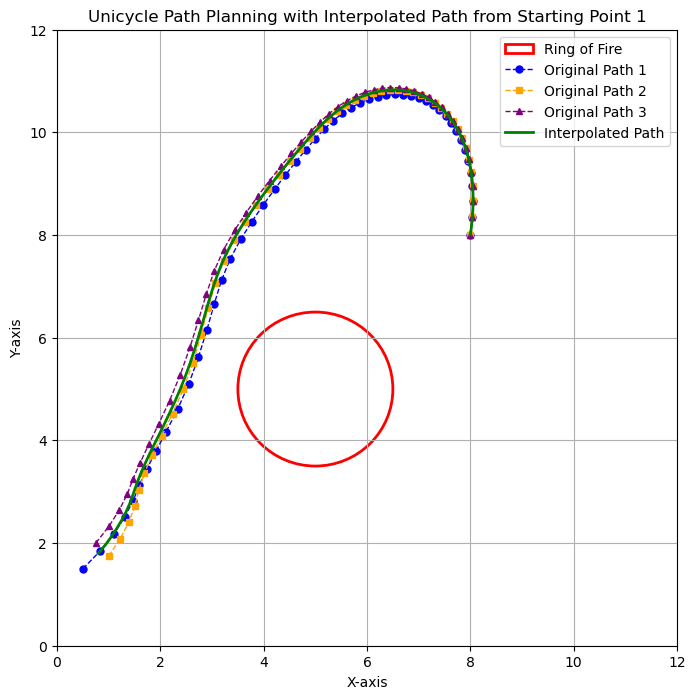

In [76]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the ring of fire
ring = Circle((5, 5), 1.5, color="red", fill=False, linewidth=2, label="Ring of Fire")
ax.add_patch(ring)

# Plot the three original paths
colors = ["blue", "orange", "purple"]  # Different colors for the three paths
markers = ["o", "s", "^"]  # Different markers for each path
for i, path in enumerate(selected_paths):
    ax.plot(
        path[0],
        path[1],
        linestyle="--",
        marker=markers[i],
        color=colors[i],
        label=f"Original Path {i+1}",
        markersize=5,
        linewidth=1,
    )

#  Plot p(t) from 0 to 49
t_plot = np.linspace(0, 49, 100)
p_t = p(t_plot).squeeze()
ax.plot(p_t[0], p_t[1], label="Interpolated Path", color="green", linewidth=2)

# Set plot limits
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)

# Add grid, legend, and labels
ax.grid(True)
ax.legend()
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_title(
    f"Unicycle Path Planning with Interpolated Path from Starting Point {starting_point_idx + 1}"
)


# Save fig
plt.savefig(
    f"../figs/Q8_path_{starting_point_idx + 1}.png",
    transparent=True,
    bbox_inches="tight",
)

# Display the plot
plt.show()

e) Discuss how your algorithm would need to be modified (if at all) if more obstacles like the ring of ﬁre were to be introduced.